# Analyzing Growth Curves

## Overview
A key feature of bacterial physiology is the growth rate -- a quantitative trait that relates the accumulation of biomass to the number of actively translating ribosomes. This parameter, often denoted mathematically as $\lambda$, corresponds to the so-called regime of steady-state exponential growth where the accumulation of biomass is, well, exponential with time. In the lab, we measure the optical density (typically at a wavelength of 600 nm) of a culture $OD$ which is proportional to the biomass. Thus, given trustworthy measurements of the $OD$, we can relate these measurements to the growth rate $\lambda$ as a function of time as 

$$
OD(t) = OD_0\exp\left[\lambda t\right], \tag{1}
$$

Where $OD_0$ is the optical density of the culture at time $t=0$. The functions of the `cremerlab.growth` module described here provide utilities for the reading and cleaning of raw optical density measurements taken at the spectrophotometer as well as a function for a robust Bayesian inference of the key parameters of Equation 1.

## Tabulating your data

Optical density measurements in the lab are typically taken as either by hand using a spectrophotometer or using a plate reader. We will discuss how to parse and analyze data from the plate reader in a separate tutorial (2021/04/01 - Module still in development) and will focus here on processing readings from a spectrophotometer. 

While a digital instrument, the data from a spectrophotometer is often recorded by hand on paper as there's not a way to record and export the data in a simple and expedient manner. Thus, the data must then go through the arcane step of being manually entered into a spreadsheet to create a digital record of the data, from which we can start to estimate parameters. 

While it is tempting to use Microsoft Excel (or similar software) to make complicated spreadsheets that perform linear regressions, make plots, and summarize parameters, the resulting data then becomes a bloated file difficult to parse by eye. Instead, it is preferable to record the  data in a neat and simple format and do all of the analysis and vizualization programmatically. The functions of `cremerlab.growth` do just that. 

To keep the data simple, you should record in your notebook as few facts about the measurement as possible while keeping extraneous details (such as sample preparation) to your end-of-experiment write up. The image below shows a sample table of growth curve measurements that includes just enough information to do the analysis -- the time of the meausurement (the "Clock Time"), the particular sample ID ("Preculture"), and the optical density ("OD").

![](../images/growth_curve_notebook.png)

<div class='alert alert-info'> Here we've recorded the clock time in 24 hour format. This is highly advisable versus 12-hour time format as you don't need to specify AM or PM in your measurements.</div>

This table is in a "tidy long-form" format where each row is a single observation and each column is a dimension. Note that the identity of the preculture (or later termed the *replicate*) is considered in one of the columns, rather than having a separate column for each preculture measurement. The table is not very human readable -- which is just fine. We are reading it with our computer anyway!

After finishing the experiment, the data is tabulated into a spreadsheet exactly as is shown in the above photo and saved as a "comma separated value" file with the extension `.csv`. Using the [Python library `pandas`](https://pandas.pydata.org/docs/index.html), we can read in the data and easily display it as a table.

In [1]:
# Load the pandas module and read in the data. 
import pandas as pd
raw_data = pd.read_csv('data/growth_data.csv')

# Show the first couple of rows of the data. 
raw_data.head()

,clock_time,od_600nm,replicate
0,12:12,0.018,1
1,12:13,0.016,2
2,12:31,0.019,1
3,12:31,0.031,2
4,12:44,0.020,1


Note that here wew have renamed the "Preculture" column as `replicate` as that better captures the meaning of that identifier. We have also renamed "OD" to the more descriptive name `od_600nm` which specifies the important information of the measurement wavelength. 


## Estimating Parameters
There are a few steps we need to take to convert this data table to an inferred growth rate.

1. **Convert the `clock_time` to `elapsed_time`.** While the clock time is easy to record, it takes a bit of math to figure out how much time has elapsed from one measurement to the next. 
2. **Restrict the optical density measurements to the linear regime of the spectrophotometer.** The spectrophotometers are not linear across an infinte range of optical density measurements. For the spectrophotometers we use in lab, the linear regime is between approximately 0.04 and 0.4 at 600 nm. 
3. **Separate the replicates for independent parameter estimates.** These data correspond to different biological replicates which whould be treated as independent experiments

Rather than making a bunch of different CSV files, we can do all of this with a single function, `cremerlab.growth.infer_growth_rate` which takes as an argument the raw data (as a pandas DataFrame), the range of OD values to consider (as `od_bounds`) and the column(s) we want to group by.

We direct the reader to the Appendix section of this tutorial for an explanation of the actual parameter inference. In short, the `cremerlab.growth.infer_growth_rate` function uses optimization by minimization to find the *maximal a posteriori* parameter set which maximizes the posterior probability distribution over the growth rate λ, the initial optical density $OD_0$, and a homoscedastic error σ. 

In [2]:
# Load the module and infer the growth rate
import cremerlab.growth
data, parameters = cremerlab.growth.infer_growth_rate(raw_data, 
                                                      od_bounds=[0.04, 0.4], 
                                                      groupby=['replicate'])

Estimating parameters...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2117: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2118: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
Estimating parameters...: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]



Parameter Estimate Summary


Parameter Estimates for grouping ['replicate']: 1
------------------------------------------------------------
growth rate,  λ = 0.91 ± 0.014 [per unit time]
initial OD, OD_0 = 0.04 ± 0.014 [a.u.]
homoscedastic error, σ = 0.00 ± 0.001 [a.u.]


Parameter Estimates for grouping ['replicate']: 2
------------------------------------------------------------
growth rate,  λ = 0.86 ± 0.024 [per unit time]
initial OD, OD_0 = 0.04 ± 0.024 [a.u.]
homoscedastic error, σ = 0.01 ± 0.002 [a.u.]





The above code cell produces a few outputs worth noting. 

1. It reports a `RuntimeWarning` indicating that the parameter ran into a calcualtion error. This is a common error and can typically be ignored. 
2. It prints a progress bar indicating how long its taking to do the estimate.
3. It prints out a summary of the the resulting parameters. This reports the *maximum a posterior* value of each parameter (the MAP) as well as the 95% Bayesian credible interval for the parameters (which you can think of as the uncertainty, but *not* a standard deviation). This feature can be turned off by passing the argument `print_params=False` to the function.

These three features provide a sense of how the parameter estimation went, what the problems were, and what the resulting parameters are. 

Aside from printing out the parameter summaries, the function returns two pandas DataFrames, `data`, and `parameters`. The DataFrame `data` looks as follows

In [3]:
data.head()

,elapsed_time_hr,od_600nm,replicate
0,0.000000,0.044,1
1,0.216667,0.052,1
2,0.416667,0.064,1
3,0.600000,0.072,1
4,0.750000,0.080,1


This DataFrame is almost the same as what we originally passed into `cremerlab.growth.infer_growth_rate`, but reflects the changes that were made to the DataFrame to conduct the inference. The `clock_time` column is gone, replaced with `elapsed_time_hr` and the 
optical density column `od_600nm` has only the values which were within our specified `od_bounds`.

The DataFrame `parameters` looks like this:

In [4]:
parameters.head()

,cred_int,map_val,parameter,replicate
0,0.013520,0.909128,growth_rate,1
1,0.001142,0.040896,od_init,1
2,0.000870,0.002742,sigma,1
0,0.024006,0.862343,growth_rate,2
1,0.002290,0.042587,od_init,2


This contains the parameter estimates as well as their credible intervals (CI's). This is also a long-form tidy DataFrame with each row corresponding to a single estimate.

## Visualing the Inference
Doing the estimate is only half of the battle. You should always plot your data along with the information about the inference to see if the results pass the eye test. 

Creating a visualization of these data can be included as an argument in the `cremerlab.growth.infer_growth_rate` function, which makes a plot of the measurements, line of best fit, and approximate posterior distribution marginalized over the homoscedastic error σ. To generate this fiz, we just have to pass the `viz=True` argument to the inference.

Estimating parameters...:   0%|          | 0/2 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2117: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2118: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
Estimating parameters...: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Generating plot...


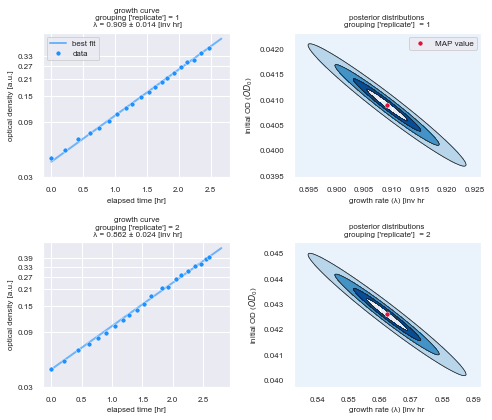

In [18]:
# Run the inference, generating a vizualization.
data, parameters, plot = cremerlab.growth.infer_growth_rate(raw_data, 
                                                      od_bounds=[0.04, 0.4], 
                                                      groupby=['replicate'],
                                                      viz=True,
                                                      print_params=False)

The above performs the inference and returns a plot  summarizing the inference all in one go. The plots on the left-hand side show the data (points) superimposed with the line of best fit given the inferred parameters. The plots on the right-hand side show the approximation of the marginal posterior distribution over the parameters. The contours represent the 1st (smallest) through 4th (largest) standard deviations of the posterior. The red point indicates the MAP, which is used to generate the fits on the left-hand plots.

In passing `viz = True` as an argument, the function now returns a `plot` object which is a matplotlib Figure canvas and the corresponding axes. With this, we can continue to manipulate the plots as we see fit and can even save it as a PDF as follows:

In [17]:
# Unpack the plot objects and save the plot to disk.
fig, ax = plot 
plt.savefig('./inference_plot.pdf')

<Figure size 432x288 with 0 Axes>

## Appendix: Statistical Model for Growth Rate Inference
The function `cremerlab.growth.infer_growth_rate` uses a Bayesian definition of probability to estimate the parameter values. We will leave the details of Bayesian statistics to other resources (such as this [excellent course by Justin Bois at Caltech](https://bebi103b.caltech.edu) and here introduce the statistical model employed by `cremerlab.growth.infer_growth_rate`.

### Assembling the Posterior Distribution


We are interested in estimating values for the growth rate $\lambda$ and the initial optical density $OD_0$. By Bayes' theorem, the posterior distribution of these parameters given our data (composed of time $t$ and optical density measurements $OD$) can be stated as 

$$
g(\lambda\,OD_0\,\vert\, t, OD) = \frac{f(OD\,\vert\, t, \lambda, OD_0)g(OD_0, \lambda)}{f(OD)}, \tag{A.1}
$$

where we use $g$ and $f$ to denote probability densities over parameters and data, respectively. The numerator is the product of the *likelihood* ($f(OD\,\vert\, t, \lambda, OD_0)$) and the *prior* ($g(\lambda, OD_0)$) distributions. The denominator is the likelihood marginalized over the parameters and, for our purposes, will just be treated as a normalization constant. 

#### The Likelihood Function
The likelihood captures the probability of observing our data ($OD$) at the given times $t$ given any combination of parameter values for $\lambda$ and $OD_0$. We assume that this  is described by a Gaussian distribution with a a mean $\mu$ and a standard deviation $\sigma$ of 

$$
f(OD\,\vert\,t\lambda, OD_0) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(OD - \mu)^2}{2\sigma^2}\right]. \tag{A.2}
$$

The mean $\mu$ is defined by Equation 1 for any combination of $\lambda$ and $OD_0$. 


#### The Prior Distributions
The prior distributions capture all knowledge we have of the parameters before we *ever* look  at our data. In using a normal distribution for the likelihoood, we have introduced a new parameter $\sigma$ which much also be included in our prior distributions.

Picking prior distributions often requires a lot of careful thought about the system. While we leave the details of defining priors and their effects to other resources, we can state that we know all of our parameters must be positive. Furthermore, we know that they will be relatively small as growth ratees don't typically extend past 2hr^{-1} and are often less than 1 hr$^{-1}$ for the lab strains and conditions we use. Similarly, we know that the initial optical density $OD_0$ by design is small and close to 0.04, as that is the lower obund we consider for the spectrophometers we typically use. Finally, we trust our experiments enough to say that the homoscedastic error $\sigma$ is going to be sufficiently small such that its well below 1, as we typically see clear exponential growth in these types of experiments. 

With the constraints in mind that all the parameters (below denoted generically as $\theta$) must be greater than zero and less than one, we choose a Gamma function as a prior distribution,

$$
g(\theta\,\vert\,\alpha, \beta) = \frac{1}{\Gamma(\alpha)}\frac{(\beta\theta)^\alpha}{\theta}\exp\left[-\beta\theta\right]. \tag{A.3}
$$
with $\alpha = 2.2$ and $\beta = 5$. These values result in  distributions where 95% of the probability density is below a parameter value of 1.

### Estimating the Parameters
It is typical practice to evaluate the posterior distribution using Markov chain Monte Carlo which is a pretty easy task given modern computational power. However, as this problem is very well defined, we've opted to evaluate this posterior distribution by using optimization by minimization. Doing so allows us to evaluate the *maximum a posterior* parameter set (colloquially termed the MAP) which represents the parameter values which maximize the posterior distribution. Given these values, we can estimate the uncertainty in each parameter by approximating the posterior distribution as a multivariate normal distribution. 

Future editions of this tutorial will go into this in more depth, but we direct the reader to [this excellent treatment of the problem](https://bebi103b.github.io/lessons/06/normal_optimization.html) in the context of biological data.